In [1]:
import sys
import os
import glob
import ipdb
import shutil
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn import metrics

In [2]:
data_directory = os.path.join("..", "data", "kNN")
activities = [
    {"name": "Biceps Curls",
     "subdirectory": "biceps_curls",
     "label": 0},
    {"name": "Triceps Curls",
     "subdirectory": "triceps_curls",
     "label": 1},
    {"name": "Russian Twists",
     "subdirectory": "russian_twists",
     "label": 2},
    {"name": "Crunches",
     "subdirectory": "crunches",
     "label": 3}]

VALIDATION_SPLIT = 0.25

In [3]:
dataset_samples = 0
dataset_label_strings = []
N_activities = 4


for activity in activities:
  subdir = os.path.join(data_directory, activity["subdirectory"], "timeframes")
  N_samples = int(len(os.listdir(subdir)) / 2) # Two files per sample (Accelerometer & Gyroscope)
  dataset_samples += N_samples

print(f"The dataset contains in total {dataset_samples} samples.")

The dataset contains in total 529 samples.


In [4]:
for k in range(N_activities):
  dataset_label_strings.append(activities[k]["name"])
dataset_label_strings

['Biceps Curls', 'Triceps Curls', 'Russian Twists', 'Crunches']

In [5]:
dataset_x = np.zeros((dataset_samples, 200, 6))
dataset_y = np.zeros(dataset_samples, dtype=int)

In [6]:
def sensor_data_normalization(data):
  mean_vals = np.mean(data, axis=0)
  return data - mean_vals
  #return data

In [7]:
sample_idx = 0
for activity in activities:
  name = activity["name"]
  subdirectory = os.path.join(data_directory, activity["subdirectory"])
  label = int(activity["label"])

  gyro_filenames = glob.glob(os.path.join(subdirectory, "timeframes", "*_gyro_sensor_data_*.npy"))
  for gyro_file in gyro_filenames:
    print("Loading {:6d} from {:6d}".format(sample_idx, dataset_samples))
    accel_file = gyro_file.replace("gyro", "accel")

    gyro_data = np.load(os.path.join(gyro_file), allow_pickle=True)
    accel_data = np.load(os.path.join(accel_file), allow_pickle=True)

    gyro_data_normalized = sensor_data_normalization(gyro_data[:,1:])
    accel_data_normalized = sensor_data_normalization(accel_data[:,1:])

    dataset_x[sample_idx, :, 0:3] = gyro_data_normalized
    dataset_x[sample_idx, :, 3:6] = accel_data_normalized

    dataset_y[sample_idx] = label
    sample_idx += 1

Loading      0 from    529
Loading      1 from    529
Loading      2 from    529
Loading      3 from    529
Loading      4 from    529
Loading      5 from    529
Loading      6 from    529
Loading      7 from    529
Loading      8 from    529
Loading      9 from    529
Loading     10 from    529
Loading     11 from    529
Loading     12 from    529
Loading     13 from    529
Loading     14 from    529
Loading     15 from    529
Loading     16 from    529
Loading     17 from    529
Loading     18 from    529
Loading     19 from    529
Loading     20 from    529
Loading     21 from    529
Loading     22 from    529
Loading     23 from    529
Loading     24 from    529
Loading     25 from    529
Loading     26 from    529
Loading     27 from    529
Loading     28 from    529
Loading     29 from    529
Loading     30 from    529
Loading     31 from    529
Loading     32 from    529
Loading     33 from    529
Loading     34 from    529
Loading     35 from    529
Loading     36 from    529
L

In [8]:
def calc_energies(data):
    N_samples = data.shape[0]
    return np.var(data,axis=0)

### Split dataset into training- and validation set

In [9]:
from numpy.random import default_rng
rng = default_rng(seed=1234) # Use seed for reproducability

N_validation_samples = int(np.floor(dataset_samples * VALIDATION_SPLIT))
N_training_samples = dataset_samples - N_validation_samples

validation_set_indices = np.zeros((N_validation_samples), dtype=int)
# Get N_validation_samples unique indices for the validation set
for k in range(N_validation_samples):
  idx_tmp = rng.integers(low=0, high=dataset_samples - 1, size=1)
  while idx_tmp in validation_set_indices:
    idx_tmp = rng.integers(low=0, high=dataset_samples - 1, size=1)
  validation_set_indices[k] = idx_tmp

validation_set_boolean_indices = np.zeros(dataset_samples, dtype=bool)
validation_set_boolean_indices[validation_set_indices] = True
training_set_boolean_indices = ~validation_set_boolean_indices


x_train = dataset_x[training_set_boolean_indices, :]
y_train = dataset_y[training_set_boolean_indices]

x_validate = dataset_x[validation_set_boolean_indices, :]
y_validate = dataset_y[validation_set_boolean_indices]

### Training-Set histogram

<AxesSubplot:ylabel='Count'>

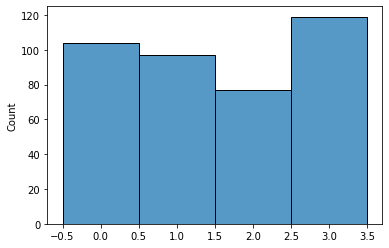

In [10]:
sns.histplot(data=y_train, stat="count", discrete=True, bins=N_activities)

### Validation-Set histogram

<AxesSubplot:ylabel='Count'>

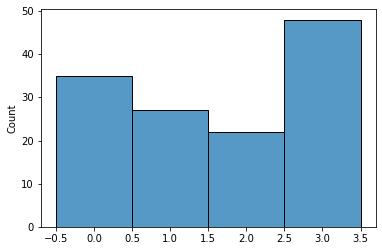

In [11]:
sns.histplot(data=y_validate, stat="count", discrete=True, bins=N_activities)

### Pair-plot of training-set

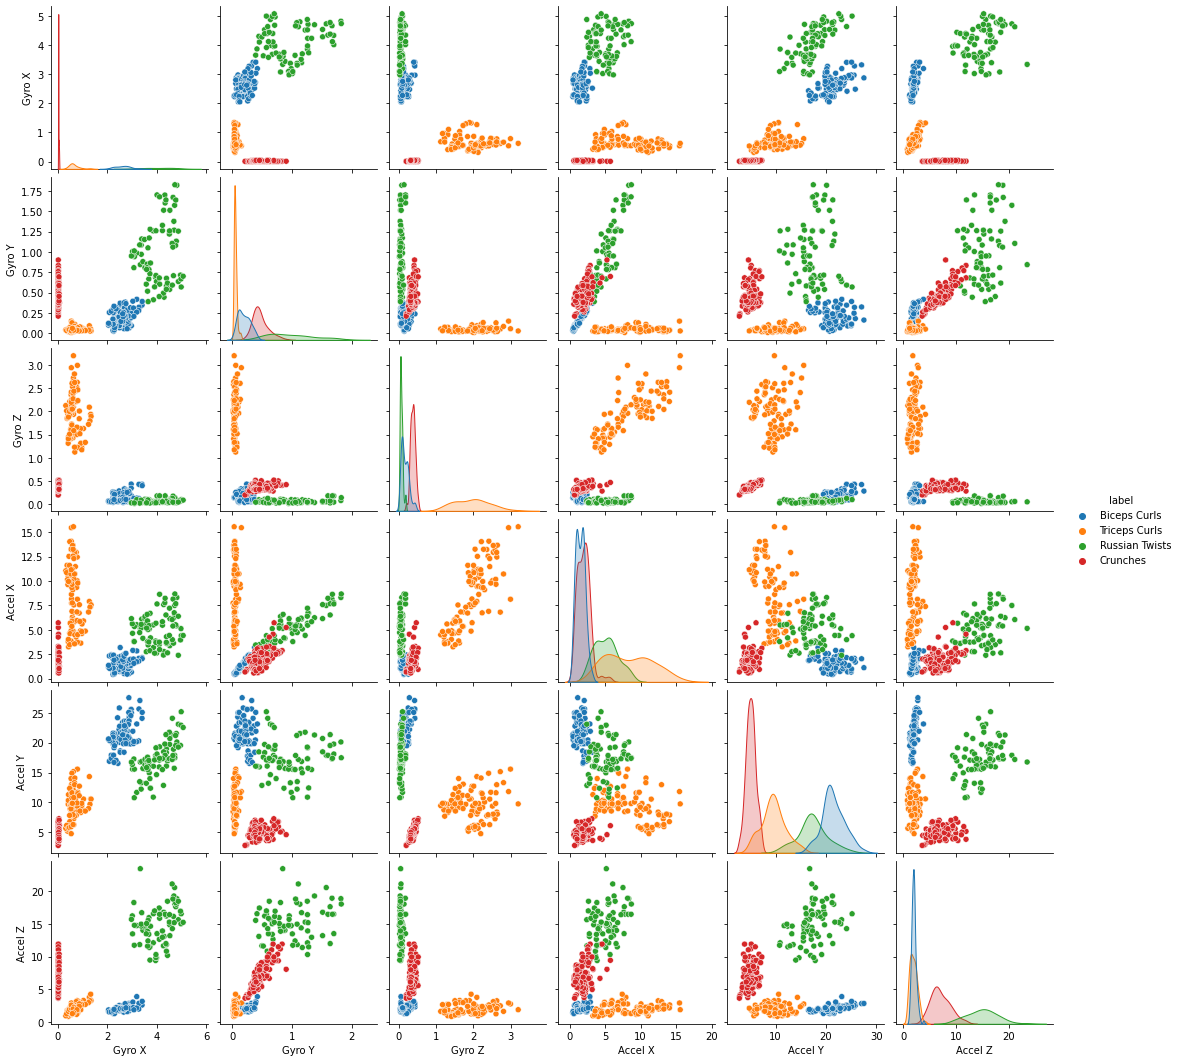

In [12]:
x_train_energies = np.zeros((N_training_samples,6))
for k in range(N_training_samples):
    x_train_energies[k,:] = calc_energies(x_train[k,:,:])

df = pd.DataFrame(x_train_energies, columns=["Gyro X", "Gyro Y", "Gyro Z", "Accel X", "Accel Y", "Accel Z"])
df["label"] = list(map(lambda x: activities[x]["name"], y_train))

sns.pairplot(df, hue="label")

### Store reference-data to file
This file is then moved to the device and loaded at runtime for the kNN classification.

In [13]:
out_filename = os.path.join("..", "data", "kNN", "kNN_reference_data.csv")
data_stacked = np.column_stack((x_train_energies, y_train))
np.savetxt(out_filename, data_stacked, delimiter=";", fmt="%e;%e;%e;%e;%e;%e;%d")

# Validate model

## Pair-plot of validation-set

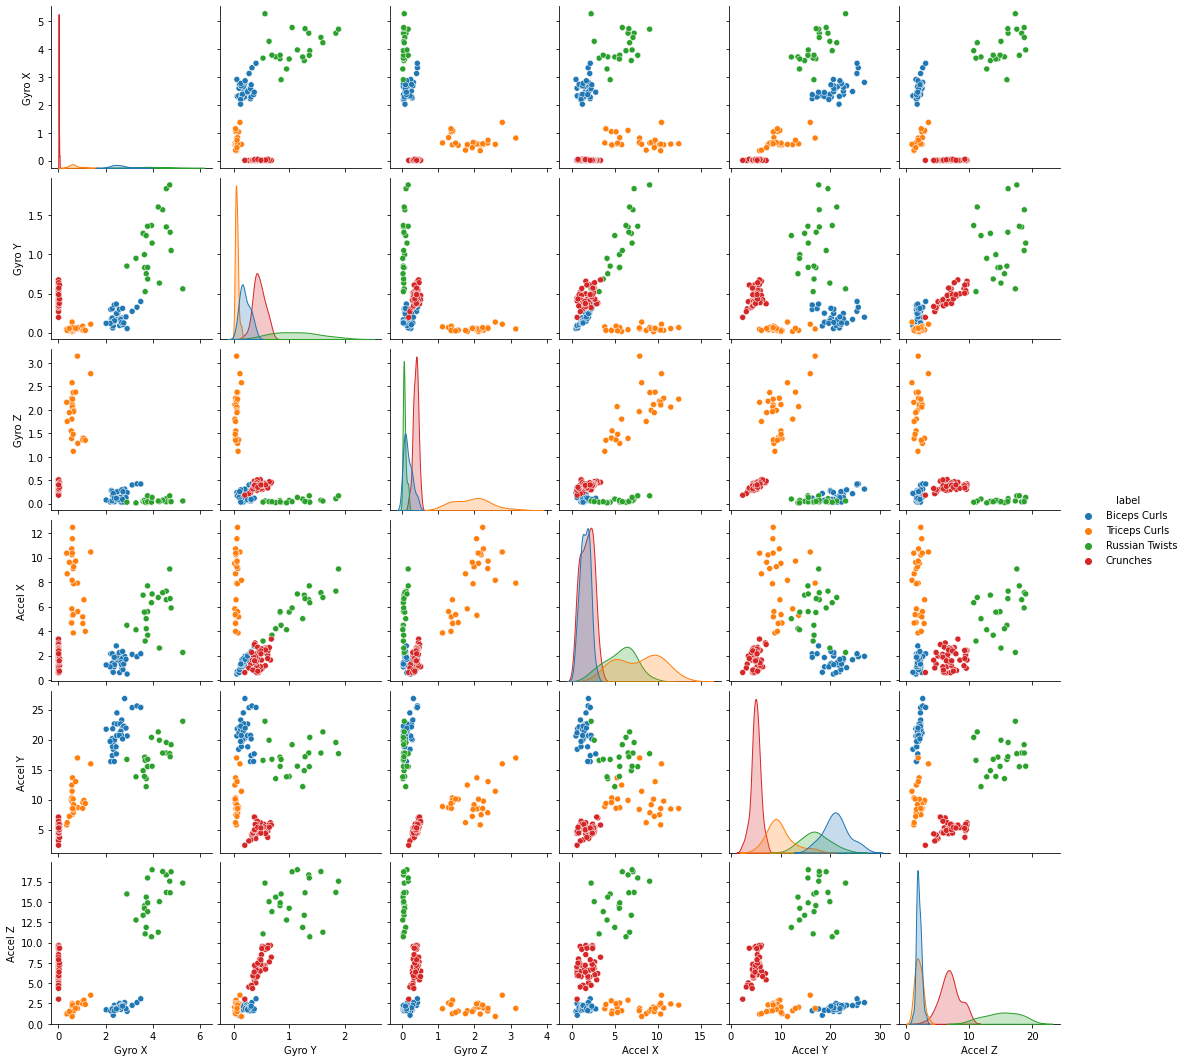

In [14]:
x_validate_energies = np.zeros((N_validation_samples,6))
for k in range(N_validation_samples):
    x_validate_energies[k,:] = calc_energies(x_validate[k,:,:])

df = pd.DataFrame(x_validate_energies, columns=["Gyro X", "Gyro Y", "Gyro Z", "Accel X", "Accel Y", "Accel Z"])
df["label"] = list(map(lambda x: activities[x]["name"], y_validate))

sns.pairplot(df, hue="label")

### Predict classes

In [15]:
def kNN(features_in, features_ref, labels_ref, k=10, N_classes=4):
    #ipdb.set_trace()
    euclidian_distances = np.linalg.norm(features_ref - features_in, axis=1)
    sorted_indices = np.argsort(euclidian_distances)
    sorted_labels = labels_ref[sorted_indices]
    
    return k_majority_voting(sorted_labels, N_classes = N_classes, k = k)
    
def k_majority_voting(data, k, N_classes):
    counters = np.zeros((N_classes), dtype=int)
    N_entries = data.shape[0]
    for l in range(k):
        counters[data[l]] += 1
        
    sorted_indices = np.argsort(counters)
    return sorted_indices[-1]

In [16]:
y_validate_predicted = np.zeros((N_validation_samples), dtype=int)

for k in range(N_validation_samples):
    y_validate_predicted[k] = kNN(
        features_in = x_validate_energies[k,:], 
        features_ref = x_train_energies, 
        labels_ref = y_train,
        k = 10,
        N_classes = 4)

In [17]:
def show_confusion_matrix(validations, predictions, labels_strings):

    matrix = metrics.confusion_matrix(validations, predictions)
    plt.figure(figsize=(6, 4))
    sns.heatmap(matrix,
                cmap='coolwarm',
                linecolor='white',
                linewidths=1,
                xticklabels=labels_strings,
                yticklabels=labels_strings,
                annot=True,
                fmt='d')
    plt.title('Confusion Matrix')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()

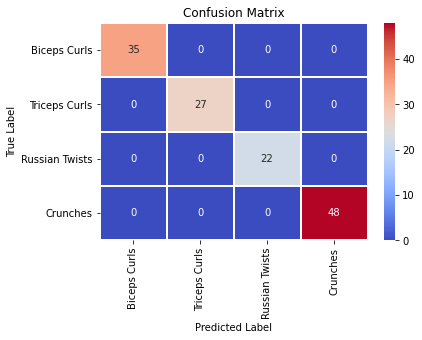

In [18]:
show_confusion_matrix(
    validations = y_validate, 
    predictions = y_validate_predicted, 
    labels_strings = df["label"].unique())

In [19]:
df["label"].unique()

array(['Biceps Curls', 'Triceps Curls', 'Russian Twists', 'Crunches'],
      dtype=object)

## Store validation-set for On-Device testing

In [20]:
test_set_dir = os.path.join("..", "data", "kNN", "validation_set")
if os.path.isdir(test_set_dir):
    shutil.rmtree(test_set_dir)
os.mkdir(test_set_dir)

for k in range(x_validate.shape[0]):
  filename = test_set_dir + "/sample_{:d}_activity_{:d}.csv".format(k, y_validate[k])
  np.savetxt(filename, x_validate[k,:,:], delimiter=";")

In [21]:
x_validate_energies[0,:]

array([ 3.12884585,  0.27299438,  0.39796275,  2.10093281, 25.34135053,
        2.27337378])

In [22]:
y_validate_predicted[k] = kNN(
        features_in = x_validate_energies[0,:], 
        features_ref = x_train_energies, 
        labels_ref = y_train,
        k = 10,
        N_classes = 4)